In [546]:
import math 
import numpy as np 
import matplotlib.pyplot as plt
import random
%matplotlib inline 

In [547]:
class Value:
    def __init__(self, data, _children=(), _op = '', label  = ''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out  = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def tanh(self):
        out = Value(np.tanh(self.data), (self,), 'tanh')
        def _backward():
            self.grad += (1 - np.tanh(self.data)**2) * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        out  = Value(0 if self.data<=0 else self.data)
        def _backward():
            self.grad += (self.data > 0) * out.grad
        out._backward = _backward
        return out
        
    def sigmoid(self):
        out = Value(1/(1+np.exp(-self.data)), (self,), 'sigmoid')
        def _backward():
            self.grad += (1/(1+np.exp(-self.data))*(1-1/(1+np.exp(-self.data)))) * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    def __sub__(self, other): # self - other
        return self + (-other)
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
  
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    
    
    


In [548]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



In [549]:
#Simple multilayer perceptron 
#inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias b  
b = Value(6.88, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [550]:
from typing import Any


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum(([wi*xi for wi, xi in zip(self.w, x)]), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]   
    
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons] 
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    
    



In [551]:
x = [2.0, 0.0]
n = MLP(3, [4,4,1])
y = n(x)
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs] # predictions
for k in range(20):
    loss = [(yout - ygt)**2 for yout, ygt in zip(ypred, ys)]
    loss = sum(loss)
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data -= 0.01 * p.grad

    ypred = [n(x) for x in xs] # predictions
    print(loss.data)



4.237874512528677
3.648658263688795
3.2895872613211576
2.9678990994944066
2.63608764808008
2.3637709562795575
1.7120313491665988
1.4111188662400271
1.2024374115828567
1.008335683806331
0.872222619204359
0.7906454368546386
0.7177246016844904
0.653850858996494
0.5937298886687191
0.543762889439953
0.5013685830572018
0.4645461289265953
0.4311910914381353
0.40350153198666694


In [552]:
# generate XOR data
xs = [
  [0.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 1.0],
]
ys = [0.0, 1.0, 1.0, 0.0] # desired targets

# create a network
n = MLP(2, [4,4, 1])

# train the network
for k in range(1000):
    # forward pass
    ypred = [n(x) for x in xs] # predictions
    # compute loss
    loss = [(yout - ygt)**2 for yout, ygt in zip(ypred, ys)]
    loss = sum(loss)
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # update parameters
    for p in n.parameters():
        p.data -= 0.01 * p.grad
    print(loss.data)



3.788710186255765
1.342179045161864
1.0463631195183865
0.9816953714741478
0.933335256361981
0.9143760560363439
0.9056803162005331
0.9017997828715624
0.8993193765406018
0.8970484780546081
0.8943074031498961
0.8905691611825618
0.8884434107123562
0.8874590151109053
0.8853354799148163
0.8847132239028332
0.8837441120253955
0.8818524421371741
0.8770118943922998
0.8739599828435648
0.8718023614528502
0.8689655772630944
0.8666672312599665
0.8658060530953577
0.8627677525220384
0.8610701445814519
0.8586376099799157
0.8565810861915868
0.8542584566008391
0.8528913935282474
0.8517660879285809
0.8520970603696949
0.8515128287357259
0.84678726090255
0.8440028631585433
0.8421347682787659
0.8406059213735417
0.8377022415083398
0.8360525181159019
0.8351547995961324
0.8334869314234672
0.8316314282961883
0.8298042146320913
0.8284623332696157
0.8263333655597717
0.8246522282010618
0.8239791431153307
0.8238685447699556
0.822194731055336
0.8217428087586721
0.8202321339744122
0.8199559346632748
0.8179959244030874

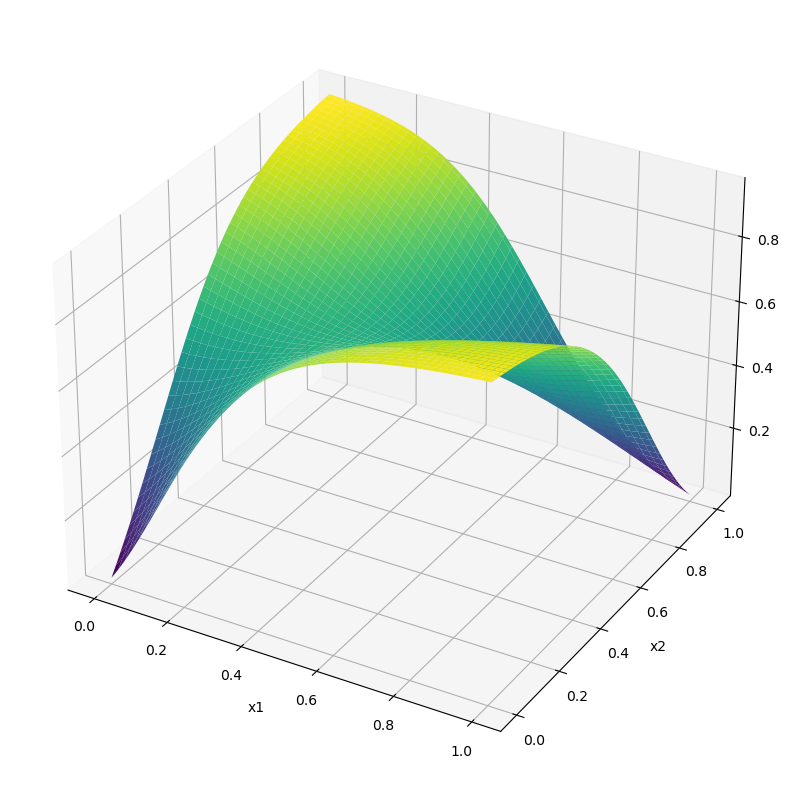

In [553]:
# Plot a 3d surface of the network's output, by predicting on a grid of inputs between 0 and 1
# and plotting the predictions as a surface
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# generate a grid of inputs between 0 and 1
X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y)
# predict on the grid
Z = np.array([n([x, y]).data for x, y in zip(X.ravel(), Y.ravel())])
Z = Z.reshape(X.shape)
# plot the predictions as a surface
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
# plot the training data
#ax.scatter(xs[0], xs[1], ys, c='r', s=100)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

